In [3]:
import numpy as np 
import sys
import pdb
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder

def get_data(x_path, y_path):
    '''
    Args:
        x_path: path to x file
        y_path: path to y file
    Returns:
        x: np array of [NUM_OF_SAMPLES x n]
        y: np array of [NUM_OF_SAMPLES]
    '''
    x = np.load(x_path)
    y = np.load(y_path)

    y = y.astype('float')
    x = x.astype('float')

    #normalize x:
    x = 2*(0.5 - x/255)
    return x, y

def get_metric(y_true, y_pred):
    '''
    Args:
        y_true: np array of [NUM_SAMPLES x r] (one hot) 
                or np array of [NUM_SAMPLES]
        y_pred: np array of [NUM_SAMPLES x r] (one hot) 
                or np array of [NUM_SAMPLES]
                
    '''
    results = classification_report(y_pred, y_true)
    print(results)

if __name__ == '__main__':

    x_train_path = "C:/Users/ANAND/Downloads/ass3_part_b/part b/x_train.npy"
    y_train_path = "C:/Users/ANAND/Downloads/ass3_part_b/part b/y_train.npy"

    X_train, y_train = get_data(x_train_path, y_train_path)

    x_test_path = "C:/Users/ANAND/Downloads/ass3_part_b/part b/x_test.npy"
    y_test_path = "C:/Users/ANAND/Downloads/ass3_part_b/part b/y_test.npy"

    X_test, y_test = get_data(x_test_path, y_test_path)

    #you might need one hot encoded y in part a,b,c,d,e
    label_encoder = OneHotEncoder(sparse_output = False)
    label_encoder.fit(np.expand_dims(y_train, axis = -1))

    y_train_onehot = label_encoder.transform(np.expand_dims(y_train, axis = -1))
    y_test_onehot = label_encoder.transform(np.expand_dims(y_test, axis = -1))

In [5]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import deque

class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, output_size):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.loss_history =[]
        self.weights, self.biases = self.initialize_weights_and_biases()
        
    def initialize_weights_and_biases(self):
        layers = [self.input_size] + self.hidden_layers + [self.output_size]
        weights = [np.random.randn(layers[i], layers[i + 1]) for i in range(len(layers) - 1)]
        biases = [np.zeros((1, layers[i + 1])) for i in range(len(layers) - 1)]
        return weights, biases

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        
        exp_x = np.exp(x)
        return exp_x / exp_x.sum(axis=1, keepdims=True)

    def forward_pass(self, X):
        self.z = []
        self.a = [X]
        for i in range(len(self.weights) - 1):
            z = np.dot(self.a[-1], self.weights[i]) + self.biases[i]
            a = self.sigmoid(z)
            self.z.append(z)
            self.a.append(a)
        output = np.dot(self.a[-1], self.weights[-1]) + self.biases[-1]
        probabilities = self.softmax(output)
        # print(probabilities.shape)
        return probabilities

    def backward(self, X, y, learning_rate):
        m = X.shape[0]
        delta_weights = [np.zeros(w.shape) for w in self.weights]
        delta_biases = [np.zeros(b.shape) for b in self.biases]

        # forward_pass 
        probabilities = self.forward_pass(X)

        # Backward pass
        error = probabilities - y
        for i in range(len(self.weights) - 1, -1, -1):
            delta_weights[i] = np.dot(self.a[i].T, error) / m
            delta_biases[i] = np.sum(error, axis=0) / m
            if i > 0:
                error = np.dot(error, self.weights[i].T) * (self.a[i] * (1 - self.a[i]))

        # Update weights and biases
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * delta_weights[i]
            self.biases[i] -= learning_rate * delta_biases[i]

    def train(self, X, y, num_epochs, learning_rate, batch_size, loss_threshold, adaptive=False):
        moving_average_window = 10
       

        for epoch in range(1, num_epochs):
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                loss = self.cross_entropy_loss(y_batch, self.forward_pass(X_batch))
                self.loss_history.append(loss)  # Append the current loss to loss_history list
                

                # Calculate moving average
                if len(self.loss_history) > moving_average_window:
                    moving_average_loss = np.abs(np.mean(self.loss_history[-moving_average_window:]) - self.loss_history[-1])
                    # print(len(self.loss_history[-moving_average_window:]))
                    
                    

                    # Check for convergence using moving average loss
                    if epoch > 1 and moving_average_loss < loss_threshold:
                        print(f"Stopping criterion met at epoch {epoch}. Moving Average Loss: {moving_average_loss:.6f}")
                        return

                self.backward(X_batch, y_batch, learning_rate)

            if adaptive:
                learning_rate = learning_rate / np.sqrt(epoch)

    def one_hot_encode(self, y, num_classes):
        return np.eye(num_classes)[y]

    def cross_entropy_loss(self, y_true, y_pred):
        return -np.sum(y_true * np.log(y_pred)) / len(y_true)
    
    def predict(self,X):
        probabilities= self.forward_pass(X)
        predictions= np.argmax(probabilities, axis=1) + 1
        return predictions 
    
    def accuracy(self, y_true, y_pred):
        return sum(y_true == y_pred) / len(y_pred) * 100
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        precision = precision_score(y, y_pred, average='weighted')
        recall = recall_score(y, y_pred, average='weighted')
        f1 = f1_score(y, y_pred, average='weighted')
        accuracy = self.accuracy(y, y_pred)

        return precision, recall, f1, accuracy
        


   

Part(a)

In [27]:

input_size = 1024
hidden_layers = [100, 50]
output_size = 5
num_epochs = 1000
learning_rate = 0.001
batch_size = 32

model = NeuralNetwork(input_size, hidden_layers, output_size)

model.train(X_train, y_train_onehot, num_epochs, learning_rate, batch_size, loss_threshold=1e-5)
predictions = model.predict(X_test)
accuracy = model.accuracy(y_test, predictions)
print(accuracy)

Stopping criterion met at epoch 50. Moving Average Loss: 0.000005
45.6


In [20]:
model.forward_pass(X_train)

array([[0.3705503 , 0.4980682 , 0.065021  , 0.02445001, 0.04191048],
       [0.21589701, 0.32014252, 0.22166133, 0.14028942, 0.10200972],
       [0.02154947, 0.08455357, 0.24526995, 0.39444545, 0.25418155],
       ...,
       [0.01214554, 0.03459179, 0.42134201, 0.30556965, 0.22635101],
       [0.01074378, 0.06685243, 0.2717247 , 0.28435578, 0.36632333],
       [0.02955735, 0.08673757, 0.34212051, 0.29531578, 0.24626878]])

Part(b)

In [33]:

#neurons in hidden layers = 1


input_size = 1024
hidden_layers = [1]
output_size = 5
num_epochs = 5000
learning_rate = 0.01
batch_size = 32



    
model_1 = NeuralNetwork(input_size, hidden_layers, output_size)

model_1.train(X_train, y_train_onehot, num_epochs, learning_rate, batch_size, loss_threshold=1e-5)
precision_1_train, recall_1_train, f1_score_1_train, accuracy_1_train = model_1.evaluate(X_train, y_train)
precision_1_test, recall_1_test, f1_score_1_test, accuracy_1_test = model_1.evaluate(X_test, y_test)
print("Metrics for training data")
print(f'Precision: {precision_1_train:.2f}')
print(f'Recall: {recall_1_train:.2f}')
print(f'F1 Score: {f1_score_1_train:.2f}')
print(f'Accuracy: {accuracy_1_train:.2f}%')

print("Metrics for testing data")
print(f'Precision: {precision_1_test:.2f}')
print(f'Recall: {recall_1_test:.2f}')
print(f'F1 Score: {f1_score_1_test:.2f}')
print(f'Accuracy: {accuracy_1_test:.2f}%')

Stopping criterion met at epoch 2. Moving Average Loss: 0.000005
Metrics for training data
Precision: 0.11
Recall: 0.18
F1 Score: 0.13
Accuracy: 17.81%
Metrics for testing data
Precision: 0.10
Recall: 0.18
F1 Score: 0.12
Accuracy: 18.00%


c:\Users\ANAND\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ANAND\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


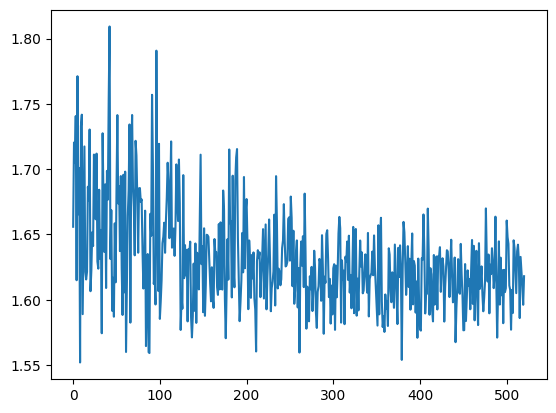

In [34]:
import matplotlib.pyplot as plt
loss = model_1.loss_history
x_val = np.arange(0,len(loss))
plt.plot(x_val, loss)

In [35]:

#neurons in hidden layers = 5
input_size = 1024
hidden_layers = [5]
output_size = 5
num_epochs = 5000
learning_rate = 0.01
batch_size = 32

model_5 = NeuralNetwork(input_size, hidden_layers, output_size)

model_5.train(X_train, y_train_onehot, num_epochs, learning_rate, batch_size, loss_threshold=1e-5)
precision_5_train, recall_5_train, f1_score_5_train, accuracy_5_train = model_5.evaluate(X_train, y_train)
precision_5_test, recall_5_test, f1_score_5_test, accuracy_5_test = model_5.evaluate(X_test, y_test)

print("Metrics for training data")
print(f'Precision: {precision_5_train:.2f}')
print(f'Recall: {recall_5_train:.2f}')
print(f'F1 Score: {f1_score_5_train:.2f}')
print(f'Accuracy: {accuracy_5_train:.2f}%')

print("Metrics for testing data")
print(f'Precision: {precision_5_test:.2f}')
print(f'Recall: {recall_5_test:.2f}')
print(f'F1 Score: {f1_score_5_test:.2f}')
print(f'Accuracy: {accuracy_5_test:.2f}%')



Stopping criterion met at epoch 8. Moving Average Loss: 0.000007
Metrics for training data
Precision: 0.25
Recall: 0.29
F1 Score: 0.18
Accuracy: 29.42%
Metrics for testing data
Precision: 0.14
Recall: 0.29
F1 Score: 0.18
Accuracy: 29.00%


c:\Users\ANAND\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
#neurons in hidden layers = 10
input_size = 1024
hidden_layers = [10]
output_size = 5
num_epochs = 5000
learning_rate = 0.01
batch_size = 32

model_10 = NeuralNetwork(input_size, hidden_layers, output_size)

model_10.train(X_train, y_train_onehot, num_epochs, learning_rate, batch_size, loss_threshold=1e-5)
precision_10_train, recall_10_train, f1_score_10_train, accuracy_10_train = model_10.evaluate(X_train, y_train)
precision_10_test, recall_10_test, f1_score_10_test, accuracy_10_test = model_10.evaluate(X_test, y_test)

print("Metrics for training data")
print(f'Precision: {precision_10_train:.2f}')
print(f'Recall: {recall_10_train:.2f}')
print(f'F1 Score: {f1_score_10_train:.2f}')
print(f'Accuracy: {accuracy_10_train:.2f}%')

print("Metrics for testing data")
print(f'Precision: {precision_10_test:.2f}')
print(f'Recall: {recall_10_test:.2f}')
print(f'F1 Score: {f1_score_10_test:.2f}')
print(f'Accuracy: {accuracy_10_test:.2f}%')

Stopping criterion met at epoch 8. Moving Average Loss: 0.000003
Metrics for training data
Precision: 0.32
Recall: 0.36
F1 Score: 0.26
Accuracy: 36.43%
Metrics for testing data
Precision: 0.23
Recall: 0.36
F1 Score: 0.26
Accuracy: 35.80%


c:\Users\ANAND\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
#neurons in hidden layers = 50
input_size = 1024
hidden_layers = [50]
output_size = 5
num_epochs = 5000
learning_rate = 0.01
batch_size = 32

model_50 = NeuralNetwork(input_size, hidden_layers, output_size)

model_50.train(X_train, y_train_onehot, num_epochs, learning_rate, batch_size, loss_threshold=1e-5)
precision_50_train, recall_50_train, f1_score_50_train, accuracy_50_train = model_50.evaluate(X_train, y_train)
precision_50_test, recall_50_test, f1_score_50_test, accuracy_50_test = model_50.evaluate(X_test, y_test)

print("Metrics for training data")
print(f'Precision: {precision_50_train:.2f}')
print(f'Recall: {recall_50_train:.2f}')
print(f'F1 Score: {f1_score_50_train:.2f}')
print(f'Accuracy: {accuracy_50_train:.2f}%')

print("Metrics for testing data")
print(f'Precision: {precision_50_test:.2f}')
print(f'Recall: {recall_50_test:.2f}')
print(f'F1 Score: {f1_score_50_test:.2f}')
print(f'Accuracy: {accuracy_50_test:.2f}%')

Stopping criterion met at epoch 11. Moving Average Loss: 0.000006
Metrics for training data
Precision: 0.43
Recall: 0.46
F1 Score: 0.43
Accuracy: 46.36%
Metrics for testing data
Precision: 0.40
Recall: 0.46
F1 Score: 0.41
Accuracy: 45.70%


In [38]:
#neurons in hidden layers = 100
input_size = 1024
hidden_layers = [100]
output_size = 5
num_epochs = 5000
learning_rate = 0.01
batch_size = 32

model_100 = NeuralNetwork(input_size, hidden_layers, output_size)

model_100.train(X_train, y_train_onehot, num_epochs, learning_rate, batch_size, loss_threshold=1e-5)
precision_100_train, recall_100_train, f1_score_100_train, accuracy_100_train = model_100.evaluate(X_train, y_train)
precision_100_test, recall_100_test, f1_score_100_test, accuracy_100_test = model_100.evaluate(X_test, y_test)

print("Metrics for training data")
print(f'Precision: {precision_100_train:.2f}')
print(f'Recall: {recall_100_train:.2f}')
print(f'F1 Score: {f1_score_100_train:.2f}')
print(f'Accuracy: {accuracy_100_train:.2f}%')

print("Metrics for testing data")
print(f'Precision: {precision_100_test:.2f}')
print(f'Recall: {recall_100_test:.2f}')
print(f'F1 Score: {f1_score_100_test:.2f}')
print(f'Accuracy: {accuracy_100_test:.2f}%')

Stopping criterion met at epoch 28. Moving Average Loss: 0.000008
Metrics for training data
Precision: 0.55
Recall: 0.56
F1 Score: 0.55
Accuracy: 56.35%
Metrics for testing data
Precision: 0.54
Recall: 0.55
F1 Score: 0.54
Accuracy: 55.00%


plotting

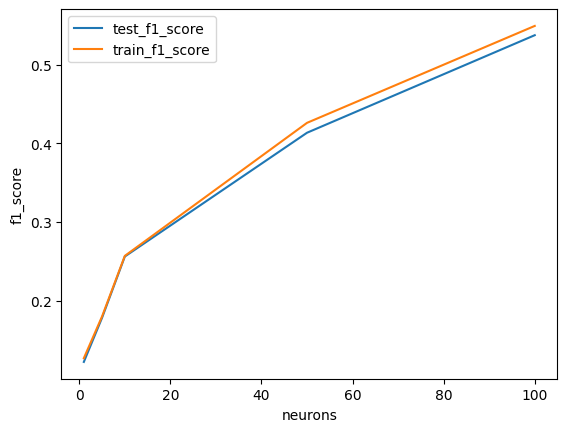

In [42]:

import matplotlib.pyplot as plt
f1_score_list_test = np.array([f1_score_1_test, f1_score_5_test, f1_score_10_test, f1_score_50_test, f1_score_100_test ])
f1_score_list_train = np.array([f1_score_1_train, f1_score_5_train, f1_score_10_train, f1_score_50_train, f1_score_100_train ])
x_val = np.array([1,5,10,50,100])

plt.plot(x_val, f1_score_list_test)
plt.plot(x_val, f1_score_list_train)
plt.xlabel('neurons')
plt.ylabel('f1_score')
plt.legend(['test_f1_score','train_f1_score'])

Part(c)

In [50]:
#hidden layers = 1
#neurons in hidden layers = [512]
input_size = 1024
hidden_layers = [512]
output_size = 5
num_epochs = 1000
learning_rate = 0.01
batch_size = 32

model_hidden_1 = NeuralNetwork(input_size, hidden_layers, output_size)

model_hidden_1.train(X_train, y_train_onehot, num_epochs, learning_rate, batch_size, loss_threshold=1e-5)
precision_hidden_1_train, recall_hidden_1_train, f1_score_hidden_1_train, accuracy_hidden_1_train = model_hidden_1.evaluate(X_train, y_train)
precision_hidden_1_test, recall_hidden_1_test, f1_score_hidden_1_test, accuracy_hidden_1_test = model_hidden_1.evaluate(X_test, y_test)

print(f"Metrics for training data with hidden layers {hidden_layers}")
print(f'Precision: {precision_hidden_1_train:.2f}')
print(f'Recall: {recall_hidden_1_train:.2f}')
print(f'F1 Score: {f1_score_hidden_1_train:.2f}')
print(f'Accuracy: {accuracy_hidden_1_train:.2f}%')

print(f"Metrics for test data with hidden layers {hidden_layers}")
print(f'Precision: {precision_hidden_1_test:.2f}')
print(f'Recall: {recall_hidden_1_test:.2f}')
print(f'F1 Score: {f1_score_hidden_1_test:.2f}')
print(f'Accuracy: {accuracy_hidden_1_test:.2f}%')

Stopping criterion met at epoch 28. Moving Average Loss: 0.000004
Metrics for training data with hidden layers [512]
Precision: 0.62
Recall: 0.61
F1 Score: 0.61
Accuracy: 60.91%
Metrics for test data with hidden layers [512]
Precision: 0.59
Recall: 0.58
F1 Score: 0.58
Accuracy: 58.00%


In [49]:
#hidden layers = 2
#neurons in hidden layers = [512 , 256]
input_size = 1024
hidden_layers = [512, 256]
output_size = 5
num_epochs = 1000
learning_rate = 0.01
batch_size = 32

model_hidden_2 = NeuralNetwork(input_size, hidden_layers, output_size)

model_hidden_2.train(X_train, y_train_onehot, num_epochs, learning_rate, batch_size, loss_threshold=1e-5)
precision_hidden_2_train, recall_hidden_2_train, f1_score_hidden_2_train, accuracy_hidden_2_train = model_hidden_2.evaluate(X_train, y_train)
precision_hidden_2_test, recall_hidden_2_test, f1_score_hidden_2_test, accuracy_hidden_2_test = model_hidden_2.evaluate(X_test, y_test)

print(f"Metrics for training data with hidden layers {hidden_layers}")
print(f'Precision: {precision_hidden_2_train:.2f}')
print(f'Recall: {recall_hidden_2_train:.2f}')
print(f'F1 Score: {f1_score_hidden_2_train:.2f}')
print(f'Accuracy: {accuracy_hidden_2_train:.2f}%')

print(f"Metrics for test data with hidden layers {hidden_layers}")
print(f'Precision: {precision_hidden_2_test:.2f}')
print(f'Recall: {recall_hidden_2_test:.2f}')
print(f'F1 Score: {f1_score_hidden_2_test:.2f}')
print(f'Accuracy: {accuracy_hidden_2_test:.2f}%')

Stopping criterion met at epoch 40. Moving Average Loss: 0.000010
Metrics for training data with hidden layers [512, 256]
Precision: 0.66
Recall: 0.67
F1 Score: 0.66
Accuracy: 66.70%
Metrics for test data with hidden layers [512, 256]
Precision: 0.62
Recall: 0.63
F1 Score: 0.62
Accuracy: 63.00%


In [53]:
#hidden layers = 3
#neurons in hidden layers = [512 , 256 , 128]
input_size = 1024
hidden_layers = [512, 256, 128]
output_size = 5
num_epochs = 1000
learning_rate = 0.01
batch_size = 32

model_hidden_3 = NeuralNetwork(input_size, hidden_layers, output_size)

model_hidden_3.train(X_train, y_train_onehot, num_epochs, learning_rate, batch_size, loss_threshold=1e-5)
precision_hidden_3_train, recall_hidden_3_train, f1_score_hidden_3_train, accuracy_hidden_3_train = model_hidden_3.evaluate(X_train, y_train)
precision_hidden_3_test, recall_hidden_3_test, f1_score_hidden_3_test, accuracy_hidden_3_test = model_hidden_3.evaluate(X_test, y_test)

print(f"Metrics for training data with hidden layers {hidden_layers}")
print(f'Precision: {precision_hidden_3_train:.2f}')
print(f'Recall: {recall_hidden_3_train:.2f}')
print(f'F1 Score: {f1_score_hidden_3_train:.2f}')
print(f'Accuracy: {accuracy_hidden_3_train:.2f}%')

print(f"Metrics for test data with hidden layers {hidden_layers}")
print(f'Precision: {precision_hidden_3_test:.2f}')
print(f'Recall: {recall_hidden_3_test:.2f}')
print(f'F1 Score: {f1_score_hidden_3_test:.2f}')
print(f'Accuracy: {accuracy_hidden_3_test:.2f}%')

Stopping criterion met at epoch 67. Moving Average Loss: 0.000001
Metrics for training data with hidden layers [512, 256, 128]
Precision: 0.71
Recall: 0.70
F1 Score: 0.70
Accuracy: 70.05%
Metrics for test data with hidden layers [512, 256, 128]
Precision: 0.64
Recall: 0.63
F1 Score: 0.63
Accuracy: 63.00%


In [54]:
#hidden layers = 4
#neurons in hidden layers = [512 , 256, 128, 64]
input_size = 1024
hidden_layers = [512, 256, 128, 64]
output_size = 5
num_epochs = 1000
learning_rate = 0.01
batch_size = 32

model_hidden_4 = NeuralNetwork(input_size, hidden_layers, output_size)

model_hidden_4.train(X_train, y_train_onehot, num_epochs, learning_rate, batch_size, loss_threshold=1e-5)
precision_hidden_4_train, recall_hidden_4_train, f1_score_hidden_4_train, accuracy_hidden_4_train = model_hidden_4.evaluate(X_train, y_train)
precision_hidden_4_test, recall_hidden_4_test, f1_score_hidden_4_test, accuracy_hidden_4_test = model_hidden_4.evaluate(X_test, y_test)

print(f"Metrics for training data with f{hidden_layers}")
print(f'Precision: {precision_hidden_4_train:.2f}')
print(f'Recall: {recall_hidden_4_train:.2f}')
print(f'F1 Score: {f1_score_hidden_4_train:.2f}')
print(f'Accuracy: {accuracy_hidden_4_train:.2f}%')

print(f"Metrics for test data with f{hidden_layers}")
print(f'Precision: {precision_hidden_4_test:.2f}')
print(f'Recall: {recall_hidden_4_test:.2f}')
print(f'F1 Score: {f1_score_hidden_4_test:.2f}')
print(f'Accuracy: {accuracy_hidden_4_test:.2f}%')

Stopping criterion met at epoch 31. Moving Average Loss: 0.000001
Metrics for training data with f[512, 256, 128, 64]
Precision: 0.66
Recall: 0.67
F1 Score: 0.67
Accuracy: 67.37%
Metrics for test data with f[512, 256, 128, 64]
Precision: 0.65
Recall: 0.65
F1 Score: 0.65
Accuracy: 65.40%


plotting


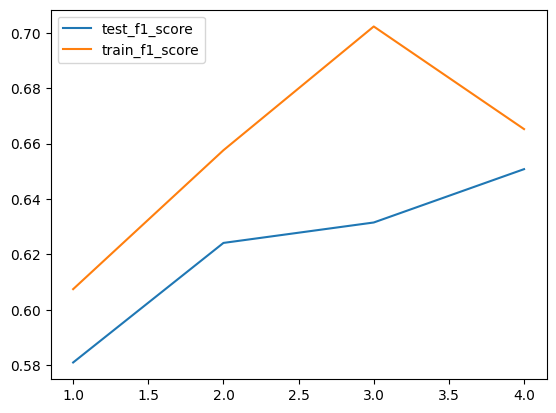

In [56]:
import matplotlib.pyplot as plt
f1_score_list_hidden_test = np.array([f1_score_hidden_1_test,f1_score_hidden_2_test,f1_score_hidden_3_test, f1_score_hidden_4_test])
f1_score_list_hidden_train = np.array([f1_score_hidden_1_train,f1_score_hidden_2_train,f1_score_hidden_3_train, f1_score_hidden_4_train])

x_val_hidden = np.array([1,2,3,4])

plt.plot(x_val_hidden, f1_score_list_hidden_test)
plt.plot(x_val_hidden, f1_score_list_hidden_train)
plt.legend(['test_f1_score','train_f1_score'])

Text(0, 0.5, 'accuracy')

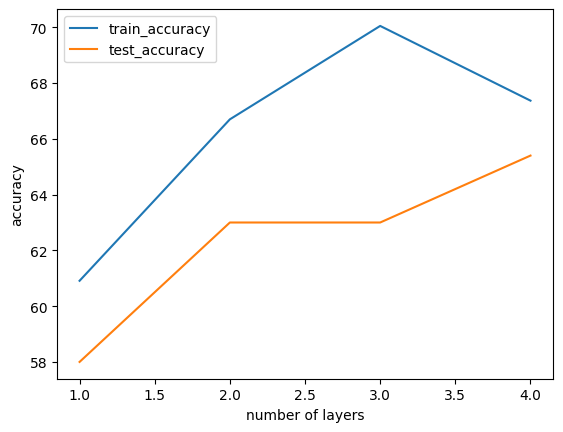

In [60]:
hidden_train_accuracy = [accuracy_hidden_1_train,accuracy_hidden_2_train,accuracy_hidden_3_train,accuracy_hidden_4_train]
hidden_test_accuracy = [accuracy_hidden_1_test,accuracy_hidden_2_test,accuracy_hidden_3_test,accuracy_hidden_4_test]
x_acc_val = [1,2,3,4]
plt.plot(x_acc_val,hidden_train_accuracy)
plt.plot(x_acc_val,hidden_test_accuracy)

plt.legend(['train_accuracy','test_accuracy'])
plt.xlabel('number of layers')
plt.ylabel('accuracy')

part(d)

In [61]:
#hidden layers = 1
#neurons in hidden layers = [512]
input_size = 1024
hidden_layers = [512]
output_size = 5
num_epochs = 1000
learning_rate = 0.01
batch_size = 32

model_hidden_1_adaptive = NeuralNetwork(input_size, hidden_layers, output_size)

model_hidden_1_adaptive.train(X_train, y_train_onehot, num_epochs, learning_rate, batch_size, loss_threshold=1e-5,adaptive=True)
precision_hidden_1_train_adaptive, recall_hidden_1_train_adaptive, f1_score_hidden_1_train_adaptive, accuracy_hidden_1_train_adaptive = model_hidden_1_adaptive.evaluate(X_train, y_train)
precision_hidden_1_test_adaptive, recall_hidden_1_test_adaptive, f1_score_hidden_1_test_adaptive, accuracy_hidden_1_test_adaptive = model_hidden_1_adaptive.evaluate(X_test, y_test)

print(f"Metrics for training data with f{hidden_layers}")
print(f'Precision: {precision_hidden_1_train_adaptive:.2f}')
print(f'Recall: {recall_hidden_1_train_adaptive:.2f}')
print(f'F1 Score: {f1_score_hidden_1_train_adaptive:.2f}')
print(f'Accuracy: {accuracy_hidden_1_train_adaptive:.2f}%')

print(f"Metrics for test data with f{hidden_layers}")
print(f'Precision: {precision_hidden_1_test_adaptive:.2f}')
print(f'Recall: {recall_hidden_1_test_adaptive:.2f}')
print(f'F1 Score: {f1_score_hidden_1_test_adaptive:.2f}')
print(f'Accuracy: {accuracy_hidden_1_test_adaptive:.2f}%')

Metrics for training data with f[512]
Precision: 0.49
Recall: 0.49
F1 Score: 0.49
Accuracy: 49.37%
Metrics for test data with f[512]
Precision: 0.49
Recall: 0.49
F1 Score: 0.49
Accuracy: 49.20%


In [62]:
#hidden layers = 2
#neurons in hidden layers = [512, 256]
input_size = 1024
hidden_layers = [512, 256]
output_size = 5
num_epochs = 1000
learning_rate = 0.01
batch_size = 32

model_hidden_2_adaptive = NeuralNetwork(input_size, hidden_layers, output_size)

model_hidden_2_adaptive.train(X_train, y_train_onehot, num_epochs, learning_rate, batch_size, loss_threshold=1e-5,adaptive=True)
precision_hidden_2_train_adaptive, recall_hidden_2_train_adaptive, f1_score_hidden_2_train_adaptive, accuracy_hidden_2_train_adaptive = model_hidden_2_adaptive.evaluate(X_train, y_train)
precision_hidden_2_test_adaptive, recall_hidden_2_test_adaptive, f1_score_hidden_2_test_adaptive, accuracy_hidden_2_test_adaptive = model_hidden_2_adaptive.evaluate(X_test, y_test)

print(f"Metrics for training data with f{hidden_layers}")
print(f'Precision: {precision_hidden_2_train_adaptive:.2f}')
print(f'Recall: {recall_hidden_2_train_adaptive:.2f}')
print(f'F1 Score: {f1_score_hidden_2_train_adaptive:.2f}')
print(f'Accuracy: {accuracy_hidden_2_train_adaptive:.2f}%')

print(f"Metrics for test data with f{hidden_layers}")
print(f'Precision: {precision_hidden_2_test_adaptive:.2f}')
print(f'Recall: {recall_hidden_2_test_adaptive:.2f}')
print(f'F1 Score: {f1_score_hidden_2_test_adaptive:.2f}')
print(f'Accuracy: {accuracy_hidden_2_test_adaptive:.2f}%')

Metrics for training data with f[512, 256]
Precision: 0.54
Recall: 0.54
F1 Score: 0.54
Accuracy: 54.06%
Metrics for test data with f[512, 256]
Precision: 0.53
Recall: 0.53
F1 Score: 0.53
Accuracy: 52.50%


In [4]:
#hidden layers = 3
#neurons in hidden layers = [512, 256, 128]
input_size = 1024
hidden_layers = [512, 256, 128]
output_size = 5
num_epochs = 1000
learning_rate = 0.01
batch_size = 32

model_hidden_3_adaptive = NeuralNetwork(input_size, hidden_layers, output_size)

model_hidden_3_adaptive.train(X_train, y_train_onehot, num_epochs, learning_rate, batch_size, loss_threshold=1e-5,adaptive=True)
precision_hidden_3_train_adaptive, recall_hidden_3_train_adaptive, f1_score_hidden_3_train_adaptive, accuracy_hidden_3_train_adaptive = model_hidden_3_adaptive.evaluate(X_train, y_train)
precision_hidden_3_test_adaptive, recall_hidden_3_test_adaptive, f1_score_hidden_3_test_adaptive, accuracy_hidden_3_test_adaptive = model_hidden_3_adaptive.evaluate(X_test, y_test)

print(f"Metrics for training data with f{hidden_layers}")
print(f'Precision: {precision_hidden_3_train_adaptive:.2f}')
print(f'Recall: {recall_hidden_3_train_adaptive:.2f}')
print(f'F1 Score: {f1_score_hidden_3_train_adaptive:.2f}')
print(f'Accuracy: {accuracy_hidden_3_train_adaptive:.2f}%')

print(f"Metrics for test data with f{hidden_layers}")
print(f'Precision: {precision_hidden_3_test_adaptive:.2f}')
print(f'Recall: {recall_hidden_3_test_adaptive:.2f}')
print(f'F1 Score: {f1_score_hidden_3_test_adaptive:.2f}')
print(f'Accuracy: {accuracy_hidden_3_test_adaptive:.2f}%')

Metrics for training data with f[512, 256, 128]
Precision: 0.52
Recall: 0.52
F1 Score: 0.52
Accuracy: 52.28%
Metrics for test data with f[512, 256, 128]
Precision: 0.51
Recall: 0.50
F1 Score: 0.50
Accuracy: 50.20%


In [6]:
#hidden layers = 4
#neurons in hidden layers = [512, 256, 128, 64]
input_size = 1024
hidden_layers = [512, 256, 128, 64]
output_size = 5
num_epochs = 1000
learning_rate = 0.01
batch_size = 32

model_hidden_4_adaptive = NeuralNetwork(input_size, hidden_layers, output_size)

model_hidden_4_adaptive.train(X_train, y_train_onehot, num_epochs, learning_rate, batch_size, loss_threshold=1e-5,adaptive=True)
precision_hidden_4_train_adaptive, recall_hidden_4_train_adaptive, f1_score_hidden_4_train_adaptive, accuracy_hidden_4_train_adaptive = model_hidden_4_adaptive.evaluate(X_train, y_train)
precision_hidden_4_test_adaptive, recall_hidden_4_test_adaptive, f1_score_hidden_4_test_adaptive, accuracy_hidden_4_test_adaptive = model_hidden_4_adaptive.evaluate(X_test, y_test)

print(f"Metrics for training data with f{hidden_layers}")
print(f'Precision: {precision_hidden_4_train_adaptive:.2f}')
print(f'Recall: {recall_hidden_4_train_adaptive:.2f}')
print(f'F1 Score: {f1_score_hidden_4_train_adaptive:.2f}')
print(f'Accuracy: {accuracy_hidden_4_train_adaptive:.2f}%')

print(f"Metrics for test data with f{hidden_layers}")
print(f'Precision: {precision_hidden_4_test_adaptive:.2f}')
print(f'Recall: {recall_hidden_4_test_adaptive:.2f}')
print(f'F1 Score: {f1_score_hidden_4_test_adaptive:.2f}')
print(f'Accuracy: {accuracy_hidden_4_test_adaptive:.2f}%')

Metrics for training data with f[512, 256, 128, 64]
Precision: 0.53
Recall: 0.55
F1 Score: 0.53
Accuracy: 54.74%
Metrics for test data with f[512, 256, 128, 64]
Precision: 0.52
Recall: 0.53
F1 Score: 0.52
Accuracy: 53.00%


Text(0, 0.5, 'accuracy')

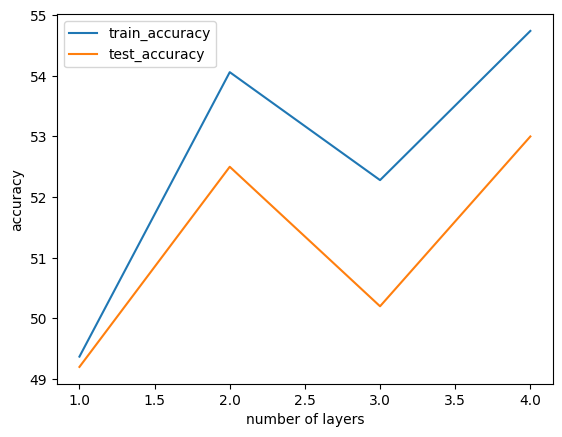

In [9]:
hidden_train_accuracy_adaptive = [49.37, 54.06, 52.28,54.74]
hidden_test_accuracy_adaptive = [49.20,52.50,50.20,53.00]

hidden_f1_score_train_adaptive = [0.49,0.54,0.52,0.53]
hidden_f1_score_test_adaptive = [0.49,0.53,0.50,0.52]
x_acc_val = [1,2,3,4]
plt.plot(x_acc_val,hidden_train_accuracy_adaptive)
plt.plot(x_acc_val,hidden_test_accuracy_adaptive)

plt.legend(['train_accuracy','test_accuracy'])
plt.xlabel('number of layers')
plt.ylabel('accuracy')

Text(0, 0.5, 'f1_score')

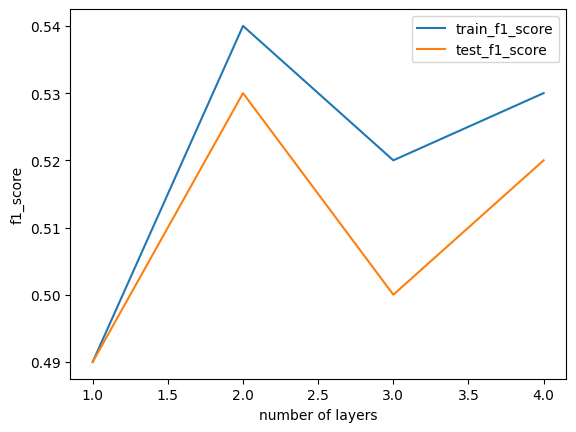

In [10]:
plt.plot(x_acc_val,hidden_f1_score_train_adaptive)
plt.plot(x_acc_val,hidden_f1_score_test_adaptive)

plt.legend(['train_f1_score','test_f1_score'])
plt.xlabel('number of layers')
plt.ylabel('f1_score')

Part(e)

In [15]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

class NeuralNetwork_relu:
    def __init__(self, input_size, hidden_layers, output_size):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.weights, self.biases = self.initialize_weights_and_biases()
        
    def initialize_weights_and_biases(self):
        layers = [self.input_size] + self.hidden_layers + [self.output_size]
        weights = [np.random.randn(layers[i], layers[i + 1]) for i in range(len(layers) - 1)]
        biases = [np.zeros((1, layers[i + 1])) for i in range(len(layers) - 1)]
        return weights, biases

    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0) 

    def softmax(self, x):
        exp_x = np.exp(x)
        return exp_x / exp_x.sum(axis=1, keepdims=True)

    def forward_pass(self, X):
        self.z = []
        self.a = [X]
        for i in range(len(self.weights) - 1):
            z = np.dot(self.a[-1], self.weights[i]) + self.biases[i]
            a = self.relu(z)
            self.z.append(z)
            self.a.append(a)
        output = np.dot(self.a[-1], self.weights[-1]) + self.biases[-1]
        probabilities = self.softmax(output)
        return probabilities

    def backward(self, X, y, learning_rate):
        m = X.shape[0]
        delta_weights = [np.zeros(w.shape) for w in self.weights]
        delta_biases = [np.zeros(b.shape) for b in self.biases]

        # Forward pass
        probabilities = self.forward_pass(X)

        # Backward pass
        error = probabilities - y
        for i in range(len(self.weights) - 1, -1, -1):
            delta_weights[i] = np.dot(self.a[i].T, error) / m
            delta_biases[i] = np.sum(error, axis=0) / m
            if i > 0:
                error = np.dot(error, self.weights[i].T) * self.relu_derivative(self.z[i - 1])

        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * delta_weights[i]
            self.biases[i] -= learning_rate * delta_biases[i]

    def train(self, X, y, num_epochs, learning_rate, batch_size, loss_threshold):
        prev_loss = float('inf')
        for epoch in range(num_epochs):
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                loss = self.cross_entropy_loss(y_batch, self.forward_pass(X_batch))
                if (prev_loss - loss) < loss_threshold:
                    print(f"Stopping criterion met at epoch {epoch + 1}. Loss: {loss:.6f}")
                    prev_loss = loss
                    return
                     
                
                self.backward(X_batch, y_batch, learning_rate)

    def one_hot_encode(self, y, num_classes):
        return np.eye(num_classes)[y]

    def cross_entropy_loss(self, y_true, y_pred):
        return -np.sum(y_true * np.log(y_pred)) / len(y_true)
    
    def predict(self,X):
        probabilities= self.forward_pass(X)
        predictions= np.argmax(probabilities, axis=1) + 1
        
        return predictions 
    
    def accuracy(self, y_true, y_pred):
        return sum(y_true == y_pred) / len(y_pred) * 100
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        precision = precision_score(y, y_pred, average='weighted')
        recall = recall_score(y, y_pred, average='weighted')
        f1 = f1_score(y, y_pred, average='weighted')
        accuracy = self.accuracy(y, y_pred)

        return precision, recall, f1, accuracy
        


   

In [22]:
input_size = 1024
hidden_layers = [128, 64]
output_size = 5
num_epochs = 1000
learning_rate = 0.01
batch_size = 32

model_relu = NeuralNetwork(input_size, hidden_layers, output_size)

model_relu.train(X_train, y_train_onehot, num_epochs, learning_rate, batch_size, loss_threshold=1e-3,adaptive=True)
precision_relu_train, recall_relu_train, f1_score_relu_train, accuracy_relu_train = model_relu.evaluate(X_train, y_train)
precision_relu_test, recall_relu_test, f1_score_relu_test, accuracy_relu_test = model_relu.evaluate(X_test, y_test)

print(f"Metrics for training data with f{hidden_layers}")
print(f'Precision: {precision_relu_train:.2f}')
print(f'Recall: {recall_relu_train:.2f}')
print(f'F1 Score: {f1_score_relu_train:.2f}')
print(f'Accuracy: {accuracy_relu_train:.2f}%')

print(f"Metrics for test data with f{hidden_layers}")
print(f'Precision: {precision_relu_test:.2f}')
print(f'Recall: {recall_relu_test:.2f}')
print(f'F1 Score: {f1_score_relu_test:.2f}')
print(f'Accuracy: {accuracy_relu_test:.2f}%')

Stopping criterion met at epoch 2. Moving Average Loss: 0.000844
Metrics for training data with f[128, 64]
Precision: 0.43
Recall: 0.45
F1 Score: 0.43
Accuracy: 44.64%
Metrics for test data with f[128, 64]
Precision: 0.44
Recall: 0.45
F1 Score: 0.43
Accuracy: 44.50%


In [ ]:
import numpy as np 
import sys
import pdb
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder

def get_data(x_path, y_path):
    '''
    Args:
        x_path: path to x file
        y_path: path to y file
    Returns:
        x: np array of [NUM_OF_SAMPLES x n]
        y: np array of [NUM_OF_SAMPLES]
    '''
    x = np.load(x_path)
    y = np.load(y_path)

    y = y.astype('float')
    x = x.astype('float')

    #normalize x:
    x = 2*(0.5 - x/255)
    return x, y

def get_metric(y_true, y_pred):
    '''
    Args:
        y_true: np array of [NUM_SAMPLES x r] (one hot) 
                or np array of [NUM_SAMPLES]
        y_pred: np array of [NUM_SAMPLES x r] (one hot) 
                or np array of [NUM_SAMPLES]
                
    '''
    results = classification_report(y_pred, y_true)
    print(results)

if __name__ == '__main__':

    x_train_path = "C:/Users/ANAND/Downloads/ass3_part_b/part b/x_train.npy"
    y_train_path = "C:/Users/ANAND/Downloads/ass3_part_b/part b/y_train.npy"

    X_train, y_train = get_data(x_train_path, y_train_path)

    x_test_path = "C:/Users/ANAND/Downloads/ass3_part_b/part b/x_test.npy"
    y_test_path = "C:/Users/ANAND/Downloads/ass3_part_b/part b/y_test.npy"

    X_test, y_test = get_data(x_test_path, y_test_path)

    #you might need one hot encoded y in part a,b,c,d,e
    label_encoder = OneHotEncoder(sparse_output = False)
    label_encoder.fit(np.expand_dims(y_train, axis = -1))

    y_train_onehot = label_encoder.transform(np.expand_dims(y_train, axis = -1))
    y_test_onehot = label_encoder.transform(np.expand_dims(y_test, axis = -1))
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

class NeuralNetwork_relu:
    def __init__(self, input_size, hidden_layers, output_size):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.weights, self.biases = self.initialize_weights_and_biases()
        self.loss_history = []
        
    def initialize_weights_and_biases(self):
        layers = [self.input_size] + self.hidden_layers + [self.output_size]
        weights = [np.random.randn(layers[i], layers[i + 1]) for i in range(len(layers) - 1)]
        biases = [np.zeros((1, layers[i + 1])) for i in range(len(layers) - 1)]
        return weights, biases

    def relu(self, x):
        return np.maximum(0, x)
    
    def reluDerivative(self,xArray):
        return np.heaviside(xArray,0)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=0,keepdims=True))
        
        return exp_x / exp_x.sum(axis=1, keepdims=True)
    
    # def log_softmax(self,x):
    #     return np.exp(x - np.max(x,axis=0))
        # return np.log(e_x / e_x.sum(axis=0, keepdims = True))
    def min_max_scaling(self,arr):
        min_val = np.min(arr)
        max_val = np.max(arr)
        scaled_arr = (arr - min_val) / (max_val - min_val)
        return scaled_arr


    def forward_pass(self, X):
        self.z = []
        self.a = [X]
        for i in range(len(self.weights) - 1):
            z = np.dot(self.a[-1], self.weights[i]) + self.biases[i]
            z_scaled = self.min_max_scaling(z)
            
            # Apply ReLU activation and clip the values to prevent exploding gradients
            a = self.relu(z) # You can adjust the clip range as needed
            
            self.z.append(z)
            self.a.append(a)
        output = np.dot(self.a[-1], self.weights[-1]) + self.biases[-1]
        
       
        scaled_output = self.min_max_scaling(output)
        # print(f"output {scaled_output}")
        # print(output)
        # Applying softmax without clipping here
        probabilities = self.softmax(scaled_output)
        
        return probabilities

        


    def backward(self, X, y, learning_rate, gradient_clip_value):
        m = X.shape[0]
        delta_weights = [np.zeros(w.shape) for w in self.weights]
        delta_biases = [np.zeros(b.shape) for b in self.biases]

        # forward_pass 
        probabilities = self.forward_pass(X)

        # Backward pass
        error = probabilities - y
        for i in range(len(self.weights) - 1, -1, -1):
            delta_weights[i] = np.dot(self.a[i].T, error) / m
            delta_biases[i] = np.sum(error, axis=0) / m
            if i > 0:
                error = np.dot(error, self.weights[i].T) * self.reluDerivative(self.z[i-1])

            # Clip gradients to prevent exploding gradients
            if gradient_clip_value is not None:
                delta_weights[i] = delta_weights[i]
                delta_biases[i] = delta_biases[i]

        # Update weights and biases
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * delta_weights[i]
            self.biases[i] -= learning_rate * delta_biases[i]

    def train(self, X, y, num_epochs, learning_rate, batch_size, loss_threshold, adaptive=False):
        moving_average_window = 10
       

        for epoch in range(1, num_epochs):
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                loss = self.cross_entropy_loss(y_batch, self.forward_pass(X_batch))
                
                self.loss_history.append(loss)  # Append the current loss to loss_history list
                

                # Calculate moving average
                if len(self.loss_history) > moving_average_window:
                    moving_average_loss = np.abs(np.mean(self.loss_history[-moving_average_window:]) - self.loss_history[-1])
                    # print(len(self.loss_history[-moving_average_window:]))
                    
                    

                    # Check for convergence using moving average loss
                    if epoch > 1 and moving_average_loss < loss_threshold:
                        print(f"Stopping criterion met at epoch {epoch}. Moving Average Loss: {moving_average_loss:.6f}")
                        return

                self.backward(X_batch, y_batch, learning_rate,5)

            if adaptive:
                learning_rate = learning_rate / np.sqrt(epoch)
                

    def one_hot_encode(self, y, num_classes):
        return np.eye(num_classes)[y]

    def cross_entropy_loss(self, y_true, y_pred):
        
        
        return -np.sum(y_true * np.log(y_pred)) / len(y_true)
    
    def predict(self,X):
        probabilities= self.forward_pass(X)
        predictions= np.argmax(probabilities, axis=1) + 1
        
        return predictions 
    
    def accuracy(self, y_true, y_pred):
        return sum(y_true == y_pred) / len(y_pred) * 100
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        
        precision = precision_score(y, y_pred, average='weighted',zero_division=1)
        recall = recall_score(y, y_pred, average='weighted',zero_division=1)
        f1 = f1_score(y, y_pred, average='weighted',zero_division=1)
        accuracy = self.accuracy(y, y_pred)

        return precision, recall, f1, accuracy
        


   
input_size = 1024
hidden_layers = [512]
output_size = 5
num_epochs = 1000
learning_rate = 1e-5
batch_size = 32

model_relu = NeuralNetwork_relu(input_size, hidden_layers, output_size)

model_relu.train(X_train, y_train_onehot, num_epochs, learning_rate, batch_size, loss_threshold=1e-5,adaptive=True)
precision_relu_train, recall_relu_train, f1_score_relu_train, accuracy_relu_train = model_relu.evaluate(X_train, y_train)
precision_relu_test, recall_relu_test, f1_score_relu_test, accuracy_relu_test = model_relu.evaluate(X_test, y_test)

print(f"Metrics for training data with f{hidden_layers}")
print(f'Precision: {precision_relu_train:.2f}')
print(f'Recall: {recall_relu_train:.2f}')
print(f'F1 Score: {f1_score_relu_train:.2f}')
print(f'Accuracy: {accuracy_relu_train:.2f}%')

print(f"Metrics for test data with f{hidden_layers}")
print(f'Precision: {precision_relu_test:.2f}')
print(f'Recall: {recall_relu_test:.2f}')
print(f'F1 Score: {f1_score_relu_test:.2f}')
print(f'Accuracy: {accuracy_relu_test:.2f}%')
input_size = 1024
hidden_layers = [512,256]
output_size = 5
num_epochs = 1000
learning_rate = 1e-5
batch_size = 32

model_relu_2 = NeuralNetwork_relu(input_size, hidden_layers, output_size)

model_relu_2.train(X_train, y_train_onehot, num_epochs, learning_rate, batch_size, loss_threshold=1e-5,adaptive=True)
precision_relu_train_2, recall_relu_train_2, f1_score_relu_train_2, accuracy_relu_train_2 = model_relu_2.evaluate(X_train, y_train)
precision_relu_test_2, recall_relu_test_2, f1_score_relu_test_2, accuracy_relu_test_2 = model_relu_2.evaluate(X_test, y_test)

print(f"Metrics for training data with f{hidden_layers}")
print(f'Precision: {precision_relu_train_2:.2f}')
print(f'Recall: {recall_relu_train_2:.2f}')
print(f'F1 Score: {f1_score_relu_train_2:.2f}')
print(f'Accuracy: {accuracy_relu_train_2:.2f}%')

print(f"Metrics for test data with f{hidden_layers}")
print(f'Precision: {precision_relu_test_2:.2f}')
print(f'Recall: {recall_relu_test_2:.2f}')
print(f'F1 Score: {f1_score_relu_test_2:.2f}')
print(f'Accuracy: {accuracy_relu_test_2:.2f}%')
input_size = 1024
hidden_layers = [512,256,128]
output_size = 5
num_epochs = 1000
learning_rate = 1e-6
batch_size = 32

model_relu_3 = NeuralNetwork_relu(input_size, hidden_layers, output_size)

model_relu_3.train(X_train, y_train_onehot, num_epochs, learning_rate, batch_size, loss_threshold=1e-7,adaptive=True)
precision_relu_train_3, recall_relu_train_3, f1_score_relu_train_3, accuracy_relu_train_3 = model_relu_3.evaluate(X_train, y_train)
precision_relu_test_3, recall_relu_test_3, f1_score_relu_test_3, accuracy_relu_test_3 = model_relu_3.evaluate(X_test, y_test)

print(f"Metrics for training data with f{hidden_layers}")
print(f'Precision: {precision_relu_train_3:.2f}')
print(f'Recall: {recall_relu_train_3:.2f}')
print(f'F1 Score: {f1_score_relu_train_3:.2f}')
print(f'Accuracy: {accuracy_relu_train_3:.2f}%')

print(f"Metrics for test data with f{hidden_layers}")
print(f'Precision: {precision_relu_test_3:.2f}')
print(f'Recall: {recall_relu_test_3:.2f}')
print(f'F1 Score: {f1_score_relu_test_3:.2f}')
print(f'Accuracy: {accuracy_relu_test_3:.2f}%')
input_size = 1024
hidden_layers = [512,256,128,64]
output_size = 5
num_epochs = 1000
learning_rate = 0.0000001
batch_size = 32

model_relu_4 = NeuralNetwork_relu(input_size, hidden_layers, output_size)

model_relu_4.train(X_train, y_train_onehot, num_epochs, learning_rate, batch_size, loss_threshold=1e-5,adaptive=True)
precision_relu_train_4, recall_relu_train_4, f1_score_relu_train_4, accuracy_relu_train_4 = model_relu_4.evaluate(X_train, y_train)
precision_relu_test_4, recall_relu_test_4, f1_score_relu_test_4, accuracy_relu_test_4 = model_relu_4.evaluate(X_test, y_test)

print(f"Metrics for training data with f{hidden_layers}")
print(f'Precision: {precision_relu_train_4:.2f}')
print(f'Recall: {recall_relu_train_4:.2f}')
print(f'F1 Score: {f1_score_relu_train_4:.2f}')
print(f'Accuracy: {accuracy_relu_train_4:.2f}%')

print(f"Metrics for test data with f{hidden_layers}")
print(f'Precision: {precision_relu_test_4:.2f}')
print(f'Recall: {recall_relu_test_4:.2f}')
print(f'F1 Score: {f1_score_relu_test_4:.2f}')
print(f'Accuracy: {accuracy_relu_test_4:.2f}%')
import matplotlib.pyplot as plt
relu_train_f1_score = [0.16,0.25,0.33,0.28]
relu_test_f1_score = [0.20,0.30,0.37,0.50]
x_acc_val = [1,2,3,4]
plt.plot(x_acc_val,relu_train_f1_score)
plt.plot(x_acc_val,relu_test_f1_score)

plt.legend(['train_f1_score','test_f1_score'])
plt.xlabel('number of layers')
plt.ylabel('f1_score')
relu_train_acc = [18.35,27.13,37.53,32.65]
relu_test_acc= [18.40,30.70,37.70,36.00]
x_val = [1,2,3,4]
plt.plot(x_val,relu_train_acc)
plt.plot(x_val,relu_test_acc)

plt.legend(['train_accuracy','test_accuracy'])
plt.xlabel('number of layers')
plt.ylabel('accuracy')

In [ ]:
import numpy as np 
import sys
import pdb
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder

def get_data(x_path, y_path):
    '''
    Args:
        x_path: path to x file
        y_path: path to y file
    Returns:
        x: np array of [NUM_OF_SAMPLES x n]
        y: np array of [NUM_OF_SAMPLES]
    '''
    x = np.load(x_path)
    y = np.load(y_path)

    y = y.astype('float')
    x = x.astype('float')

    #normalize x:
    x = 2*(0.5 - x/255)
    return x, y

def get_metric(y_true, y_pred):
    '''
    Args:
        y_true: np array of [NUM_SAMPLES x r] (one hot) 
                or np array of [NUM_SAMPLES]
        y_pred: np array of [NUM_SAMPLES x r] (one hot) 
                or np array of [NUM_SAMPLES]
                
    '''
    results = classification_report(y_pred, y_true)
    print(results)

if __name__ == '__main__':

    x_train_path = "C:/Users/ANAND/Downloads/ass3_part_b/part b/x_train.npy"
    y_train_path = "C:/Users/ANAND/Downloads/ass3_part_b/part b/y_train.npy"

    X_train, y_train = get_data(x_train_path, y_train_path)

    x_test_path = "C:/Users/ANAND/Downloads/ass3_part_b/part b/x_test.npy"
    y_test_path = "C:/Users/ANAND/Downloads/ass3_part_b/part b/y_test.npy"

    X_test, y_test = get_data(x_test_path, y_test_path)

    #you might need one hot encoded y in part a,b,c,d,e
    label_encoder = OneHotEncoder(sparse_output = False)
    label_encoder.fit(np.expand_dims(y_train, axis = -1))

    y_train_onehot = label_encoder.transform(np.expand_dims(y_train, axis = -1))
    y_test_onehot = label_encoder.transform(np.expand_dims(y_test, axis = -1))
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt

def train_and_evaluate(hidden_layer_sizes, X_train, y_train, X_test, y_test, num_epochs=200):
    mlp_classifier = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation='relu', solver='sgd',
                                   alpha=0, batch_size=32, learning_rate='invscaling', max_iter=1, random_state=42)
    
    train_loss_history = []
    test_metrics = []
    train_metrics = []
    
    for epoch in range(num_epochs):
        mlp_classifier.partial_fit(X_train, y_train, classes=np.unique(y_train))
        train_loss = mlp_classifier.loss_
        train_loss_history.append(train_loss)

        if len(train_loss_history) > 1 and abs(train_loss_history[-2] - train_loss_history[-1]) < 1e-5:
            print(f"Stopping criterion met at epoch {epoch}. Training Loss: {train_loss:.6f}")
            break
    
    y_pred_test = mlp_classifier.predict(X_test)
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    f1 = f1_score(y_test, y_pred_test, average='weighted')
    accuracy_test = accuracy_score(y_test, y_pred_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test,average='weighted')
    precision_test = precision_score(y_test, y_pred_test, average='weighted')
    
    train_metrics.append([accuracy_test, f1_test, recall_test, precision_test])
    
    y_pred_train = mlp_classifier.predict(X_train)
    f1_train = f1_score(y_train, y_pred_train, average='weighted')
    accuracy_train = accuracy_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train,average='weighted')
    precision_train = precision_score(y_train, y_pred_train, average='weighted')
    
    train_metrics.append([accuracy_train, f1_train, recall_train, precision_test])
    
    
    return f1, accuracy, train_loss_history, train_metrics, test_metrics

hidden_layer_sizes_list = [[512], [512, 256], [512, 256, 128], [512, 256, 128, 64]]
f1_scores = []
accuracies = []
for hidden_layer_sizes in hidden_layer_sizes_list:
    f1, accuracy, train_loss_history, train_metrics, test_metrics = train_and_evaluate(hidden_layer_sizes, X_train, y_train, X_test, y_test)
    f1_scores.append(f1)
    accuracies.append(accuracy)

# Plotting F1 score
plt.figure(figsize=(8, 6))
plt.plot([str(hidden) for hidden in hidden_layer_sizes_list], f1_scores, marker='o', color='blue', label='F1 Score')
plt.xlabel('Hidden Layer Sizes')
plt.ylabel('F1 Score')
plt.title('F1 Score for Different Hidden Layer Sizes')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Plotting accuracy
plt.figure(figsize=(8, 6))
plt.plot([str(hidden) for hidden in hidden_layer_sizes_list], accuracies, marker='o', color='green', label='Accuracy')
plt.xlabel('Hidden Layer Sizes')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Hidden Layer Sizes')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
